## Подключение библиотек

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error
from sklearn import set_config

## Настройки и константы

In [3]:
set_config(display='diagram')
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [4]:
SEED = 42
RANGE = (-5, 5)
N_SAMPLES = 50
DEGREES = [x for x in range(15)]

## Датасет "Предсказание оттока пользователей"

Ссылка на датасет https://www.kaggle.com/c/advanced-dls-spring-2021/

In [5]:
df = pd.read_csv('./train.csv')

Случайные 5 строк датасета

In [6]:
df.sample(n=5, random_state=SEED)

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
1448,9,45.40000,418.8,Male,0,No,No,No,No phone service,DSL,No,No,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,1
4792,37,70.35000,2552.9,Male,0,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,0
8,50,105.95000,5341.8,Male,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,No,Yes,No,Yes,Yes,Month-to-month,No,Credit card (automatic),1
3964,44,100.10000,4378.35,Male,0,No,No,Yes,No,Fiber optic,No,No,Yes,Yes,Yes,Yes,Two year,No,Bank transfer (automatic),0
240,25,20.95000,495.15,Male,0,Yes,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Bank transfer (automatic),0


Общая информация

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   int64  
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5282 non-null   object 
 3   Sex                       5282 non-null   object 
 4   IsSeniorCitizen           5282 non-null   int64  
 5   HasPartner                5282 non-null   object 
 6   HasChild                  5282 non-null   object 
 7   HasPhoneService           5282 non-null   object 
 8   HasMultiplePhoneNumbers   5282 non-null   object 
 9   HasInternetService        5282 non-null   object 
 10  HasOnlineSecurityService  5282 non-null   object 
 11  HasOnlineBackup           5282 non-null   object 
 12  HasDeviceProtection       5282 non-null   object 
 13  HasTechSupportAccess      5282 non-null   object 
 14  HasOnlin

Изменяем тип колонки `IsSeniorCitizen`

In [8]:
df['IsSeniorCitizen'] = df['IsSeniorCitizen'].astype(object)
df['IsSeniorCitizen']

0       0
1       0
2       0
3       1
4       0
       ..
5277    0
5278    0
5279    0
5280    0
5281    0
Name: IsSeniorCitizen, Length: 5282, dtype: object

Заполняем пробелы в колонке `TotalSpent` нулями и меняем тип на вещественный

In [9]:
df['TotalSpent'] = df['TotalSpent'].replace(' ', 0).astype(float)
df['TotalSpent']

0      1026.35000
1      1872.20000
2        75.90000
3      2570.00000
4      6758.45000
          ...    
5277     82.15000
5278   2188.45000
5279     55.05000
5280   2215.25000
5281   1375.60000
Name: TotalSpent, Length: 5282, dtype: float64

Список всех колонок датасета

In [10]:
df.columns

Index(['ClientPeriod', 'MonthlySpending', 'TotalSpent', 'Sex',
       'IsSeniorCitizen', 'HasPartner', 'HasChild', 'HasPhoneService',
       'HasMultiplePhoneNumbers', 'HasInternetService',
       'HasOnlineSecurityService', 'HasOnlineBackup', 'HasDeviceProtection',
       'HasTechSupportAccess', 'HasOnlineTV', 'HasMovieSubscription',
       'HasContractPhone', 'IsBillingPaperless', 'PaymentMethod', 'Churn'],
      dtype='object')

Списки колонок для удобства работы

In [11]:
# Числовые признаки
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

# Категориальные признаки
cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

feature_cols = num_cols + cat_cols

# Целевой признак
target_col = 'Churn'

Описание числовых признаков

In [12]:
df[feature_cols].describe()

,ClientPeriod,MonthlySpending,TotalSpent
count,5282.00000,5282.00000,5282.00000
mean,32.39701,64.92475,2287.48616
std,24.55033,30.17646,2269.04920
min,0.00000,18.25000,0.00000
25%,9.00000,35.46250,395.72500
50%,29.00000,70.40000,1405.65000
75%,55.00000,90.05000,3795.21250
max,72.00000,118.75000,8684.80000


Описание категориальных

In [13]:
df[feature_cols].describe(include='O')

,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod
count,5282,5282,5282,5282,5282,5282,5282,5282,5282,5282,5282,5282,5282,5282,5282,5282
unique,2,2,2,2,2,3,3,3,3,3,3,3,3,3,2,4
top,Male,0,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check
freq,2655,4440,2705,3676,4761,2511,2341,2612,2332,2317,2604,2099,2081,2920,3148,1786


Количество объектов классов целевого признака

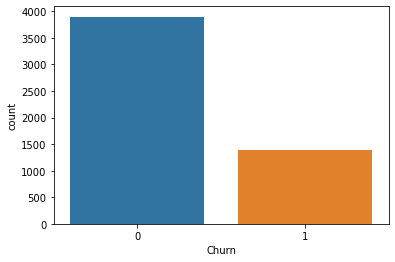

In [14]:
sns.countplot(x=df[target_col]);

## Задание (с решением)

*Условие. Обучить модель линейной регрессии. Числовые признаки отскалировать, категориальные - закодировать.*

*Вопрос. В каком порядке расположить этапы работы с моделью?*

*1. scaler and encoder -> train_test_split -> classifier*

*2. train_test_split -> scaler and encoder -> classifier*

*3. train_test_split -> classifier -> scaler and encoder*

*4. classifier -> scaler and encoder -> train_test_split*

*5. scaler and encoder -> classifier -> train_test_split*

*6. classifier -> train_test_split -> scaler and encoder*

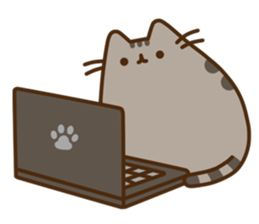

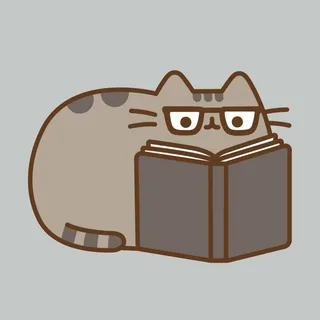

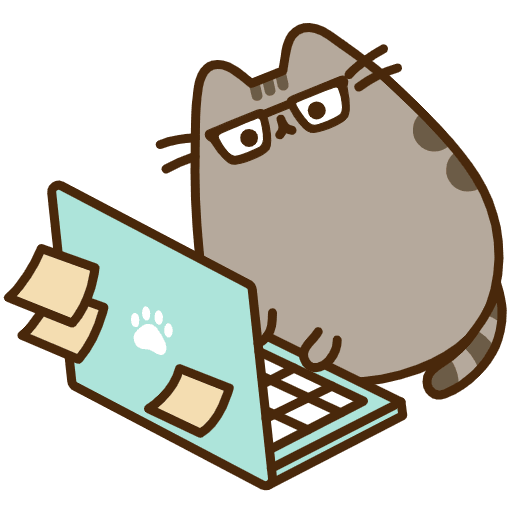

**Ответ. 2. train_test_split -> scaler and encoder -> classifier**

### Решение "в лоб"

In [15]:
X = df[feature_cols]
y = df[[target_col]]

In [16]:
print(X.shape, y.shape)

(5282, 19) (5282, 1)


In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)
display(X_train)
display(X_test)

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod
4556,31,73.55000,2094.65000,Female,1,No,No,Yes,No,Fiber optic,Yes,No,No,No,No,No,Month-to-month,Yes,Credit card (automatic)
1468,59,100.05000,6034.85000,Female,0,Yes,No,Yes,No,Fiber optic,No,Yes,No,Yes,Yes,Yes,Two year,Yes,Mailed check
3142,60,99.00000,6017.90000,Male,1,Yes,No,Yes,Yes,Fiber optic,No,No,No,Yes,Yes,Yes,Month-to-month,Yes,Electronic check
2093,6,73.85000,401.30000,Female,0,No,No,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check
1505,72,24.75000,1859.10000,Male,0,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3092,14,91.65000,1301.00000,Female,0,Yes,Yes,Yes,Yes,Fiber optic,No,No,No,Yes,Yes,No,Month-to-month,Yes,Electronic check
3772,19,73.20000,1441.10000,Female,0,Yes,No,Yes,No,Fiber optic,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check
5191,50,20.55000,1070.25000,Female,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic)
5226,8,84.50000,662.65000,Male,0,No,No,Yes,Yes,Fiber optic,No,No,No,No,No,Yes,Month-to-month,No,Bank transfer (automatic)


,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod
1448,9,45.40000,418.80000,Male,0,No,No,No,No phone service,DSL,No,No,No,No,Yes,Yes,Month-to-month,Yes,Electronic check
4792,37,70.35000,2552.90000,Male,0,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check
8,50,105.95000,5341.80000,Male,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,No,Yes,No,Yes,Yes,Month-to-month,No,Credit card (automatic)
3964,44,100.10000,4378.35000,Male,0,No,No,Yes,No,Fiber optic,No,No,Yes,Yes,Yes,Yes,Two year,No,Bank transfer (automatic)
240,25,20.95000,495.15000,Male,0,Yes,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Bank transfer (automatic)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4928,3,34.25000,139.35000,Female,0,No,No,No,No phone service,DSL,Yes,No,No,Yes,No,No,Month-to-month,No,Mailed check
3794,30,19.70000,599.25000,Female,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check
3873,8,83.55000,680.05000,Female,0,Yes,Yes,Yes,No,Fiber optic,No,Yes,No,No,Yes,No,Month-to-month,Yes,Electronic check
318,34,19.60000,678.80000,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Credit card (automatic)


In [18]:
print(y_train.shape, y_test.shape)

(4225, 1) (1057, 1)


Выделяем числовые и категориальные признаки в отдельные датасеты

In [19]:
X_train_num = X_train[num_cols]
X_test_num = X_test[num_cols]

display(X_train_num)
display(X_test_num)

,ClientPeriod,MonthlySpending,TotalSpent
4556,31,73.55000,2094.65000
1468,59,100.05000,6034.85000
3142,60,99.00000,6017.90000
2093,6,73.85000,401.30000
1505,72,24.75000,1859.10000
...,...,...,...
3092,14,91.65000,1301.00000
3772,19,73.20000,1441.10000
5191,50,20.55000,1070.25000
5226,8,84.50000,662.65000


,ClientPeriod,MonthlySpending,TotalSpent
1448,9,45.40000,418.80000
4792,37,70.35000,2552.90000
8,50,105.95000,5341.80000
3964,44,100.10000,4378.35000
240,25,20.95000,495.15000
...,...,...,...
4928,3,34.25000,139.35000
3794,30,19.70000,599.25000
3873,8,83.55000,680.05000
318,34,19.60000,678.80000


In [20]:
X_train_cat = X_train[cat_cols]
X_test_cat = X_test[cat_cols]

display(X_train_cat)
display(X_test_cat)

,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod
4556,Female,1,No,No,Yes,No,Fiber optic,Yes,No,No,No,No,No,Month-to-month,Yes,Credit card (automatic)
1468,Female,0,Yes,No,Yes,No,Fiber optic,No,Yes,No,Yes,Yes,Yes,Two year,Yes,Mailed check
3142,Male,1,Yes,No,Yes,Yes,Fiber optic,No,No,No,Yes,Yes,Yes,Month-to-month,Yes,Electronic check
2093,Female,0,No,No,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check
1505,Male,0,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3092,Female,0,Yes,Yes,Yes,Yes,Fiber optic,No,No,No,Yes,Yes,No,Month-to-month,Yes,Electronic check
3772,Female,0,Yes,No,Yes,No,Fiber optic,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check
5191,Female,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic)
5226,Male,0,No,No,Yes,Yes,Fiber optic,No,No,No,No,No,Yes,Month-to-month,No,Bank transfer (automatic)


,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod
1448,Male,0,No,No,No,No phone service,DSL,No,No,No,No,Yes,Yes,Month-to-month,Yes,Electronic check
4792,Male,0,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check
8,Male,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,No,Yes,No,Yes,Yes,Month-to-month,No,Credit card (automatic)
3964,Male,0,No,No,Yes,No,Fiber optic,No,No,Yes,Yes,Yes,Yes,Two year,No,Bank transfer (automatic)
240,Male,0,Yes,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Bank transfer (automatic)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4928,Female,0,No,No,No,No phone service,DSL,Yes,No,No,Yes,No,No,Month-to-month,No,Mailed check
3794,Female,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check
3873,Female,0,Yes,Yes,Yes,No,Fiber optic,No,Yes,No,No,Yes,No,Month-to-month,Yes,Electronic check
318,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Credit card (automatic)


С помощью `StandardScaler` преобразовываем числовые признаки

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

In [21]:
scaler = StandardScaler()
X_train_num_scaled = scaler.fit_transform(X_train_num)
X_test_num_scaled = scaler.transform(X_test_num)

display(X_train_num_scaled)
display(X_test_num_scaled)

array([[-0.05948827,  0.29437145, -0.08315114],
       [ 1.07907552,  1.17254755,  1.64975495],
       [ 1.11973852,  1.13775189,  1.64230032],
       ...,
       [ 0.71310859, -1.46198074, -0.53368385],
       [-0.99473711,  0.65724044, -0.71294696],
       [ 1.44504246, -0.33857811,  0.61186726]])

array([[-0.95407411, -0.63848353, -0.82019257],
       [ 0.18448968,  0.18832755,  0.11838793],
       [ 0.71310859,  1.368066  ,  1.34495048],
       ...,
       [-0.99473711,  0.62575866, -0.70529442],
       [ 0.0625007 , -1.49346253, -0.70584417],
       [ 0.42846764, -1.50671802, -0.66298551]])

Конвертируем в датафрейм (так более читабельно)

In [22]:
X_train_num_scaled_df = pd.DataFrame(X_train_num_scaled, columns=num_cols)
X_test_num_scaled_df = pd.DataFrame(X_test_num_scaled, columns=num_cols)

display(X_train_num_scaled_df)
display(X_test_num_scaled_df)

,ClientPeriod,MonthlySpending,TotalSpent
0,-0.05949,0.29437,-0.08315
1,1.07908,1.17255,1.64975
2,1.11974,1.13775,1.64230
3,-1.07606,0.30431,-0.82789
4,1.60769,-1.32280,-0.18675
...,...,...,...
4220,-0.75076,0.89418,-0.43220
4221,-0.54744,0.28277,-0.37058
4222,0.71311,-1.46198,-0.53368
4223,-0.99474,0.65724,-0.71295


,ClientPeriod,MonthlySpending,TotalSpent
0,-0.95407,-0.63848,-0.82019
1,0.18449,0.18833,0.11839
2,0.71311,1.36807,1.34495
3,0.46913,1.17420,0.92122
4,-0.30347,-1.44873,-0.78661
...,...,...,...
1052,-1.19805,-1.00798,-0.94310
1053,-0.10015,-1.49015,-0.74083
1054,-0.99474,0.62576,-0.70529
1055,0.06250,-1.49346,-0.70584


Посмотрим описание для отскалированных датафреймов

In [23]:
display(X_train_num_scaled_df.describe())
display(X_test_num_scaled_df.describe())

,ClientPeriod,MonthlySpending,TotalSpent
count,4225.00000,4225.00000,4225.00000
mean,-0.00000,0.00000,0.00000
std,1.00012,1.00012,1.00012
min,-1.32004,-1.53323,-1.00438
25%,-0.95407,-0.97981,-0.83565
50%,-0.14081,0.18667,-0.38842
75%,0.91642,0.83288,0.65912
max,1.60769,1.79224,2.81521


,ClientPeriod,MonthlySpending,TotalSpent
count,1057.00000,1057.00000,1057.00000
mean,-0.01340,0.04268,0.00829
std,0.99135,0.99932,0.98958
min,-1.32004,-1.53820,-1.00438
25%,-0.95407,-0.79589,-0.81428
50%,-0.14081,0.20821,-0.37817
75%,0.87576,0.86601,0.68199
max,1.60769,1.78893,2.74691


Теперь закодируем категориальные признаки с помощью `OneHotEncoder`.

*Параметр `sparse=False` "говорит", что нужно вернуть не сжатую разреженную матрицу (`scipy.sparse.csr_matrix`), а массив.*

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html

In [24]:
encoder = OneHotEncoder(sparse=False)
X_train_cat_encoded = encoder.fit_transform(X_train_cat)
X_test_cat_encoded = encoder.transform(X_test_cat)

display(X_train_cat_encoded)
display(X_test_cat_encoded)

array([[1., 0., 0., ..., 1., 0., 0.],
       [1., 0., 1., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 1., 0.],
       ...,
       [1., 0., 1., ..., 1., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [1., 0., 1., ..., 1., 0., 0.]])

array([[0., 1., 1., ..., 0., 1., 0.],
       [0., 1., 1., ..., 0., 0., 1.],
       [0., 1., 1., ..., 1., 0., 0.],
       ...,
       [1., 0., 1., ..., 0., 1., 0.],
       [0., 1., 1., ..., 1., 0., 0.],
       [0., 1., 1., ..., 0., 0., 1.]])

In [25]:
encoded_cat_cols = encoder.get_feature_names(cat_cols)
encoded_cat_cols

array(['Sex_Female', 'Sex_Male', 'IsSeniorCitizen_0', 'IsSeniorCitizen_1',
       'HasPartner_No', 'HasPartner_Yes', 'HasChild_No', 'HasChild_Yes',
       'HasPhoneService_No', 'HasPhoneService_Yes',
       'HasMultiplePhoneNumbers_No',
       'HasMultiplePhoneNumbers_No phone service',
       'HasMultiplePhoneNumbers_Yes', 'HasInternetService_DSL',
       'HasInternetService_Fiber optic', 'HasInternetService_No',
       'HasOnlineSecurityService_No',
       'HasOnlineSecurityService_No internet service',
       'HasOnlineSecurityService_Yes', 'HasOnlineBackup_No',
       'HasOnlineBackup_No internet service', 'HasOnlineBackup_Yes',
       'HasDeviceProtection_No',
       'HasDeviceProtection_No internet service',
       'HasDeviceProtection_Yes', 'HasTechSupportAccess_No',
       'HasTechSupportAccess_No internet service',
       'HasTechSupportAccess_Yes', 'HasOnlineTV_No',
       'HasOnlineTV_No internet service', 'HasOnlineTV_Yes',
       'HasMovieSubscription_No',
       'HasMovie

Конвертируем в датафрейм (так более читабельно)

*Параметр `dtype='object'` "говорит", что нужно работать с `0` и `1` как с категориями, а не как с числами.*

In [26]:
X_train_cat_encoded_df = pd.DataFrame(X_train_cat_encoded, columns=encoded_cat_cols, dtype='object')
X_test_cat_encoded_df = pd.DataFrame(X_test_cat_encoded, columns=encoded_cat_cols, dtype='object')

display(X_train_cat_encoded_df)
display(X_test_cat_encoded_df)

,Sex_Female,Sex_Male,IsSeniorCitizen_0,IsSeniorCitizen_1,HasPartner_No,HasPartner_Yes,HasChild_No,HasChild_Yes,HasPhoneService_No,HasPhoneService_Yes,...,HasMovieSubscription_Yes,HasContractPhone_Month-to-month,HasContractPhone_One year,HasContractPhone_Two year,IsBillingPaperless_No,IsBillingPaperless_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1.00000,0.00000,0.00000,1.00000,1.00000,0.00000,1.00000,0.00000,0.00000,1.00000,...,0.00000,1.00000,0.00000,0.00000,0.00000,1.00000,0.00000,1.00000,0.00000,0.00000
1,1.00000,0.00000,1.00000,0.00000,0.00000,1.00000,1.00000,0.00000,0.00000,1.00000,...,1.00000,0.00000,0.00000,1.00000,0.00000,1.00000,0.00000,0.00000,0.00000,1.00000
2,0.00000,1.00000,0.00000,1.00000,0.00000,1.00000,1.00000,0.00000,0.00000,1.00000,...,1.00000,1.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,1.00000,0.00000
3,1.00000,0.00000,1.00000,0.00000,1.00000,0.00000,1.00000,0.00000,0.00000,1.00000,...,0.00000,1.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,1.00000
4,0.00000,1.00000,1.00000,0.00000,0.00000,1.00000,0.00000,1.00000,0.00000,1.00000,...,0.00000,0.00000,0.00000,1.00000,1.00000,0.00000,0.00000,1.00000,0.00000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4220,1.00000,0.00000,1.00000,0.00000,0.00000,1.00000,0.00000,1.00000,0.00000,1.00000,...,0.00000,1.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,1.00000,0.00000
4221,1.00000,0.00000,1.00000,0.00000,0.00000,1.00000,1.00000,0.00000,0.00000,1.00000,...,0.00000,1.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,1.00000,0.00000
4222,1.00000,0.00000,1.00000,0.00000,0.00000,1.00000,0.00000,1.00000,0.00000,1.00000,...,0.00000,0.00000,0.00000,1.00000,1.00000,0.00000,0.00000,1.00000,0.00000,0.00000
4223,0.00000,1.00000,1.00000,0.00000,1.00000,0.00000,1.00000,0.00000,0.00000,1.00000,...,1.00000,1.00000,0.00000,0.00000,1.00000,0.00000,1.00000,0.00000,0.00000,0.00000


,Sex_Female,Sex_Male,IsSeniorCitizen_0,IsSeniorCitizen_1,HasPartner_No,HasPartner_Yes,HasChild_No,HasChild_Yes,HasPhoneService_No,HasPhoneService_Yes,...,HasMovieSubscription_Yes,HasContractPhone_Month-to-month,HasContractPhone_One year,HasContractPhone_Two year,IsBillingPaperless_No,IsBillingPaperless_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0.00000,1.00000,1.00000,0.00000,1.00000,0.00000,1.00000,0.00000,1.00000,0.00000,...,1.00000,1.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,1.00000,0.00000
1,0.00000,1.00000,1.00000,0.00000,1.00000,0.00000,1.00000,0.00000,0.00000,1.00000,...,0.00000,1.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,1.00000
2,0.00000,1.00000,1.00000,0.00000,0.00000,1.00000,0.00000,1.00000,0.00000,1.00000,...,1.00000,1.00000,0.00000,0.00000,1.00000,0.00000,0.00000,1.00000,0.00000,0.00000
3,0.00000,1.00000,1.00000,0.00000,1.00000,0.00000,1.00000,0.00000,0.00000,1.00000,...,1.00000,0.00000,0.00000,1.00000,1.00000,0.00000,1.00000,0.00000,0.00000,0.00000
4,0.00000,1.00000,1.00000,0.00000,0.00000,1.00000,1.00000,0.00000,0.00000,1.00000,...,0.00000,0.00000,1.00000,0.00000,0.00000,1.00000,1.00000,0.00000,0.00000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1052,1.00000,0.00000,1.00000,0.00000,1.00000,0.00000,1.00000,0.00000,1.00000,0.00000,...,0.00000,1.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,1.00000
1053,1.00000,0.00000,1.00000,0.00000,0.00000,1.00000,0.00000,1.00000,0.00000,1.00000,...,0.00000,0.00000,0.00000,1.00000,1.00000,0.00000,0.00000,0.00000,0.00000,1.00000
1054,1.00000,0.00000,1.00000,0.00000,0.00000,1.00000,0.00000,1.00000,0.00000,1.00000,...,0.00000,1.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,1.00000,0.00000
1055,0.00000,1.00000,1.00000,0.00000,0.00000,1.00000,0.00000,1.00000,0.00000,1.00000,...,0.00000,0.00000,1.00000,0.00000,1.00000,0.00000,0.00000,1.00000,0.00000,0.00000


Посмотрим описание для отскалированных датафреймов

In [27]:
display(X_train_cat_encoded_df.describe(include='O'))
display(X_test_cat_encoded_df.describe(include='O'))

,Sex_Female,Sex_Male,IsSeniorCitizen_0,IsSeniorCitizen_1,HasPartner_No,HasPartner_Yes,HasChild_No,HasChild_Yes,HasPhoneService_No,HasPhoneService_Yes,...,HasMovieSubscription_Yes,HasContractPhone_Month-to-month,HasContractPhone_One year,HasContractPhone_Two year,IsBillingPaperless_No,IsBillingPaperless_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
count,4225.00000,4225.00000,4225.00000,4225.00000,4225.00000,4225.00000,4225.00000,4225.00000,4225.00000,4225.00000,...,4225.00000,4225.00000,4225.00000,4225.00000,4225.00000,4225.00000,4225.00000,4225.00000,4225.00000,4225.00000
unique,2.00000,2.00000,2.00000,2.00000,2.00000,2.00000,2.00000,2.00000,2.00000,2.00000,...,2.00000,2.00000,2.00000,2.00000,2.00000,2.00000,2.00000,2.00000,2.00000,2.00000
top,1.00000,0.00000,1.00000,0.00000,1.00000,0.00000,1.00000,0.00000,0.00000,1.00000,...,0.00000,1.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000
freq,2118.00000,2118.00000,3548.00000,3548.00000,2157.00000,2157.00000,2933.00000,2933.00000,3783.00000,3783.00000,...,2596.00000,2346.00000,3377.00000,3194.00000,2530.00000,2530.00000,3287.00000,3317.00000,2801.00000,3270.00000


,Sex_Female,Sex_Male,IsSeniorCitizen_0,IsSeniorCitizen_1,HasPartner_No,HasPartner_Yes,HasChild_No,HasChild_Yes,HasPhoneService_No,HasPhoneService_Yes,...,HasMovieSubscription_Yes,HasContractPhone_Month-to-month,HasContractPhone_One year,HasContractPhone_Two year,IsBillingPaperless_No,IsBillingPaperless_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
count,1057.00000,1057.00000,1057.00000,1057.00000,1057.00000,1057.00000,1057.00000,1057.00000,1057.00000,1057.00000,...,1057.00000,1057.00000,1057.00000,1057.00000,1057.00000,1057.00000,1057.00000,1057.00000,1057.00000,1057.00000
unique,2.00000,2.00000,2.00000,2.00000,2.00000,2.00000,2.00000,2.00000,2.00000,2.00000,...,2.00000,2.00000,2.00000,2.00000,2.00000,2.00000,2.00000,2.00000,2.00000,2.00000
top,0.00000,1.00000,1.00000,0.00000,1.00000,0.00000,1.00000,0.00000,0.00000,1.00000,...,0.00000,1.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000
freq,548.00000,548.00000,892.00000,892.00000,548.00000,548.00000,743.00000,743.00000,978.00000,978.00000,...,626.00000,574.00000,823.00000,808.00000,618.00000,618.00000,836.00000,822.00000,695.00000,818.00000


Объединим датасеты

In [28]:
processed_X_train = X_train_num_scaled_df.join(X_train_cat_encoded_df)
processed_X_train

,ClientPeriod,MonthlySpending,TotalSpent,Sex_Female,Sex_Male,IsSeniorCitizen_0,IsSeniorCitizen_1,HasPartner_No,HasPartner_Yes,HasChild_No,...,HasMovieSubscription_Yes,HasContractPhone_Month-to-month,HasContractPhone_One year,HasContractPhone_Two year,IsBillingPaperless_No,IsBillingPaperless_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,-0.05949,0.29437,-0.08315,1.00000,0.00000,0.00000,1.00000,1.00000,0.00000,1.00000,...,0.00000,1.00000,0.00000,0.00000,0.00000,1.00000,0.00000,1.00000,0.00000,0.00000
1,1.07908,1.17255,1.64975,1.00000,0.00000,1.00000,0.00000,0.00000,1.00000,1.00000,...,1.00000,0.00000,0.00000,1.00000,0.00000,1.00000,0.00000,0.00000,0.00000,1.00000
2,1.11974,1.13775,1.64230,0.00000,1.00000,0.00000,1.00000,0.00000,1.00000,1.00000,...,1.00000,1.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,1.00000,0.00000
3,-1.07606,0.30431,-0.82789,1.00000,0.00000,1.00000,0.00000,1.00000,0.00000,1.00000,...,0.00000,1.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,1.00000
4,1.60769,-1.32280,-0.18675,0.00000,1.00000,1.00000,0.00000,0.00000,1.00000,0.00000,...,0.00000,0.00000,0.00000,1.00000,1.00000,0.00000,0.00000,1.00000,0.00000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4220,-0.75076,0.89418,-0.43220,1.00000,0.00000,1.00000,0.00000,0.00000,1.00000,0.00000,...,0.00000,1.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,1.00000,0.00000
4221,-0.54744,0.28277,-0.37058,1.00000,0.00000,1.00000,0.00000,0.00000,1.00000,1.00000,...,0.00000,1.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,1.00000,0.00000
4222,0.71311,-1.46198,-0.53368,1.00000,0.00000,1.00000,0.00000,0.00000,1.00000,0.00000,...,0.00000,0.00000,0.00000,1.00000,1.00000,0.00000,0.00000,1.00000,0.00000,0.00000
4223,-0.99474,0.65724,-0.71295,0.00000,1.00000,1.00000,0.00000,1.00000,0.00000,1.00000,...,1.00000,1.00000,0.00000,0.00000,1.00000,0.00000,1.00000,0.00000,0.00000,0.00000


Проверяем, что количество записей в датасете до и после обработки не изменилось

In [29]:
processed_X_train.shape[0] == X_train.shape[0]

True

Аналогично для тестового датасета

In [30]:
processed_X_test = X_test_num_scaled_df.join(X_test_cat_encoded_df)
processed_X_test

,ClientPeriod,MonthlySpending,TotalSpent,Sex_Female,Sex_Male,IsSeniorCitizen_0,IsSeniorCitizen_1,HasPartner_No,HasPartner_Yes,HasChild_No,...,HasMovieSubscription_Yes,HasContractPhone_Month-to-month,HasContractPhone_One year,HasContractPhone_Two year,IsBillingPaperless_No,IsBillingPaperless_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,-0.95407,-0.63848,-0.82019,0.00000,1.00000,1.00000,0.00000,1.00000,0.00000,1.00000,...,1.00000,1.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,1.00000,0.00000
1,0.18449,0.18833,0.11839,0.00000,1.00000,1.00000,0.00000,1.00000,0.00000,1.00000,...,0.00000,1.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,1.00000
2,0.71311,1.36807,1.34495,0.00000,1.00000,1.00000,0.00000,0.00000,1.00000,0.00000,...,1.00000,1.00000,0.00000,0.00000,1.00000,0.00000,0.00000,1.00000,0.00000,0.00000
3,0.46913,1.17420,0.92122,0.00000,1.00000,1.00000,0.00000,1.00000,0.00000,1.00000,...,1.00000,0.00000,0.00000,1.00000,1.00000,0.00000,1.00000,0.00000,0.00000,0.00000
4,-0.30347,-1.44873,-0.78661,0.00000,1.00000,1.00000,0.00000,0.00000,1.00000,1.00000,...,0.00000,0.00000,1.00000,0.00000,0.00000,1.00000,1.00000,0.00000,0.00000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1052,-1.19805,-1.00798,-0.94310,1.00000,0.00000,1.00000,0.00000,1.00000,0.00000,1.00000,...,0.00000,1.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,1.00000
1053,-0.10015,-1.49015,-0.74083,1.00000,0.00000,1.00000,0.00000,0.00000,1.00000,0.00000,...,0.00000,0.00000,0.00000,1.00000,1.00000,0.00000,0.00000,0.00000,0.00000,1.00000
1054,-0.99474,0.62576,-0.70529,1.00000,0.00000,1.00000,0.00000,0.00000,1.00000,0.00000,...,0.00000,1.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,1.00000,0.00000
1055,0.06250,-1.49346,-0.70584,0.00000,1.00000,1.00000,0.00000,0.00000,1.00000,0.00000,...,0.00000,0.00000,1.00000,0.00000,1.00000,0.00000,0.00000,1.00000,0.00000,0.00000


Сверяем количество строк

In [31]:
processed_X_test.shape[0] == X_test.shape[0]

True

Обучаем модель логистической регрессии

In [32]:
regressor = LinearRegression()
regressor

LinearRegression()

In [33]:
regressor.fit(processed_X_train, y_train);

In [34]:
y_pred = regressor.predict(processed_X_test)
y_pred

array([[ 0.53320312],
       [ 0.37109375],
       [ 0.23144531],
       ...,
       [ 0.60449219],
       [-0.04785156],
       [-0.00585938]])

Сверяем размерность массивов предсказанных и тестовых значений

In [35]:
len(y_pred) == y_test.shape[0]

True

### Решение с использованием ColumnTransformer и Pipeline

Как работает ColumnTransformer

https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html

In [36]:
ct = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), num_cols),
            ('cat', OneHotEncoder(), cat_cols)], sparse_threshold=0)
ct

ColumnTransformer(sparse_threshold=0,
                  transformers=[('num', StandardScaler(),
                                 ['ClientPeriod', 'MonthlySpending',
                                  'TotalSpent']),
                                ('cat', OneHotEncoder(),
                                 ['Sex', 'IsSeniorCitizen', 'HasPartner',
                                  'HasChild', 'HasPhoneService',
                                  'HasMultiplePhoneNumbers',
                                  'HasInternetService',
                                  'HasOnlineSecurityService', 'HasOnlineBackup',
                                  'HasDeviceProtection', 'HasTechSupportAccess',
                                  'HasOnlineTV', 'HasMovieSubscription',
                                  'HasContractPhone', 'IsBillingPaperless',
                                  'PaymentMethod'])])

In [37]:
transformed_X = ct.fit_transform(X_train)
display(transformed_X)

array([[-0.05948827,  0.29437145, -0.08315114, ...,  1.        ,
         0.        ,  0.        ],
       [ 1.07907552,  1.17254755,  1.64975495, ...,  0.        ,
         0.        ,  1.        ],
       [ 1.11973852,  1.13775189,  1.64230032, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [ 0.71310859, -1.46198074, -0.53368385, ...,  1.        ,
         0.        ,  0.        ],
       [-0.99473711,  0.65724044, -0.71294696, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.44504246, -0.33857811,  0.61186726, ...,  1.        ,
         0.        ,  0.        ]])

**Если нужно часть колонок оставить без изменений, установите параметр `remainder='passthrough'`, в противном случае `ColumnTransformer` при обучении их проигнорирует**

**Пайплайн**

https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html

Вспомогательная функция для построения пайплайна

In [38]:
def make_model(scaler_=StandardScaler, encoder_=OneHotEncoder, regressor_=LinearRegression):
    preprocessor_ = ColumnTransformer(
        transformers=[
            ('sca', scaler_(), num_cols),
            ('enc', encoder_(), cat_cols)])
    pipe = Pipeline(steps=[('preprocessor', preprocessor_),
                          ('regressor', regressor_())])
    return pipe

Создаем модель

In [39]:
pipe = make_model()

display(pipe)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('sca', StandardScaler(),
                                                  ['ClientPeriod',
                                                   'MonthlySpending',
                                                   'TotalSpent']),
                                                 ('enc', OneHotEncoder(),
                                                  ['Sex', 'IsSeniorCitizen',
                                                   'HasPartner', 'HasChild',
                                                   'HasPhoneService',
                                                   'HasMultiplePhoneNumbers',
                                                   'HasInternetService',
                                                   'HasOnlineSecurityService',
                                                   'HasOnlineBackup',
                                                   'HasDeviceProtection',
                                                   'HasTechSupportAccess',
                                                   'HasOnlineTV',
                                                   'HasMovieSubscription',
                                                   'HasContractPhone',
                                                   'IsBillingPaperless',
                                                   'PaymentMethod'])])),
                ('regressor', LinearRegression())])

Обучаем

In [40]:
pipe.fit(X_train, y_train);

Предсказываем

In [41]:
y_pred = pipe.predict(X_test)
y_pred

array([[ 0.52148438],
       [ 0.375     ],
       [ 0.23339844],
       ...,
       [ 0.60058594],
       [-0.05175781],
       [-0.00585938]])

Сверяем размерность массивов предсказанных и тестовых значений

In [42]:
len(y_pred) == y_test.shape[0]

True

## Полиномиальная регрессия

Возьмем функцию $ f(x) = 2\cdot x + 10\cdot sin(x) $ в качестве целевой и сгенерируем по ней шумовые точки.

In [43]:
def target_function(x):
    return 2 * x + 10 * np.sin(x)

def generate_samples():
    np.random.seed(SEED)
    x = np.random.uniform(*RANGE, size=N_SAMPLES)
    y = target_function(x) + np.random.normal(scale=4, size=N_SAMPLES)
    return x.reshape(-1, 1), y

X, y = generate_samples()

Отрисуем полученные точки

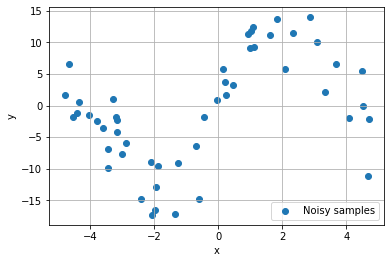

In [44]:
def plot_scatter(x, y, title=None, label='Noisy samples'):
    plt.scatter(x, y, label=label)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid(True)
    plt.title(title)
    plt.legend(loc='lower right')

plot_scatter(X, y)

Разделим датасет на тренировочную и тестовую части

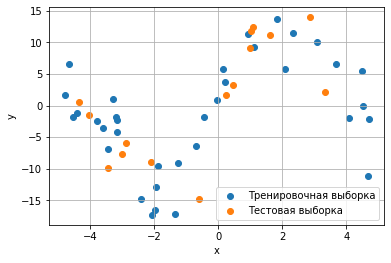

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=SEED)

plot_scatter(X_train, y_train, label='Тренировочная выборка')
plot_scatter(X_test, y_test, label='Тестовая выборка')

Пример работы полиномизации

In [46]:
PolynomialFeatures(degree=4, include_bias=False).fit_transform(X=[
    [1],
    [3],
    [4],
])

array([[  1.,   1.,   1.,   1.],
       [  3.,   9.,  27.,  81.],
       [  4.,  16.,  64., 256.]])

Вспомогательная функция для создания пайплайна

In [47]:
def make_model(degree, alpha=0, penalty=None):
    # linear regression
    if alpha == 0:
        regressor = LinearRegression()
    # lasso regression",
    elif penalty == 'L1':
        regressor = Lasso(alpha=alpha, random_state=SEED, max_iter=50000)
    # ridge regression",
    elif penalty == 'L2':
        regressor = Ridge(alpha=alpha, random_state=SEED, max_iter=50000) 
    
    
    return Pipeline([
        ('pol', PolynomialFeatures(degree, include_bias=(degree == 0))),
        ('sca', StandardScaler()),
        ('reg', regressor)
    ])

display(make_model(2))
display(make_model(2, penalty='L1', alpha=0.1))
display(make_model(2, penalty='L2', alpha=0.1))

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()), ('reg', LinearRegression())])

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()),
                ('reg', Lasso(alpha=0.1, max_iter=50000, random_state=42))])

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()),
                ('reg', Ridge(alpha=0.1, max_iter=50000, random_state=42))])

In [48]:
def plot_fit(model):
    degree = model['pol'].degree
    X_range = np.linspace(*RANGE, 1000).reshape(-1, 1)
    y_pred = model.predict(X_range)
    plot_scatter(X_train, y_train, label='Training sample')
    plot_scatter(X_test, y_test, label='Validation sample')
    plt.plot(X_range, target_function(X_range), c='green', alpha=0.2, lw=5, label='Target function')
    plt.plot(X_range, y_pred, c='red', label='Hypothesis')
    plt.ylim((min(y) - 3, max(y) + 3))
    plt.legend(loc='best')    
    plt.title(f'Polynomial approximation: degree={degree}')
    plt.show()

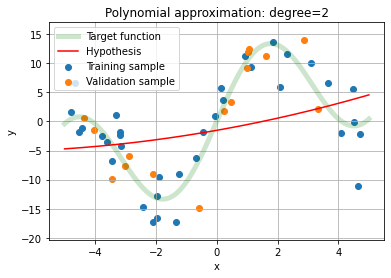

In [49]:
plot_fit(make_model(degree=2).fit(X_train, y_train))

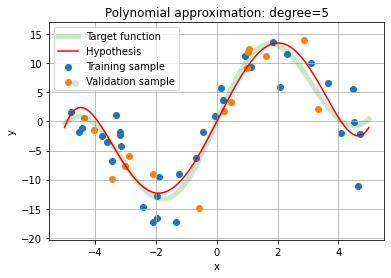

In [50]:
plot_fit(make_model(degree=5).fit(X_train, y_train))

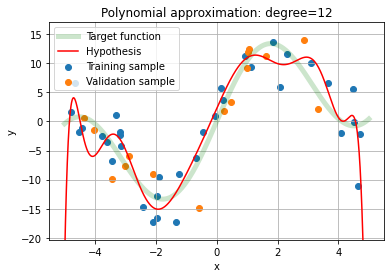

In [51]:
plot_fit(make_model(degree=12).fit(X_train, y_train))

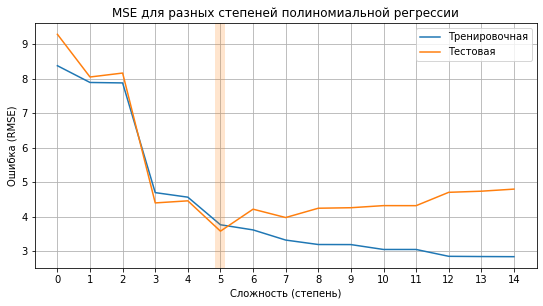

In [52]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def plot_fitting_graph(x, metric_train, metric_valid, xlabel, ylabel, 
                       custom_metric=None, custom_label='', custom_scale='log', title='Fitting graph'):
    plt.figure(figsize=(9, 4.5))
    plt.plot(x, metric_train, label='Тренировочная')
    plt.plot(x, metric_valid, color='C1', label='Тестовая')
    plt.axvline(x[np.argmin(metric_valid)], color='C1', lw=10, alpha=0.2)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.xticks(x)
    plt.legend(loc='upper right')        
    if custom_metric:
        plt.twinx()
        plt.yscale(custom_scale)
        plt.plot(x, custom_metric, alpha=0.2, lw=4, ls='dotted', color='black', label=custom_label) 
        plt.legend(loc='center right')         
    plt.show()
    
rmse_train, rmse_valid = [], []
for degree in DEGREES:
    reg = make_model(degree).fit(X_train, y_train)
    rmse_train.append(rmse(reg.predict(X_train), y_train))
    rmse_valid.append(rmse(reg.predict(X_test), y_test))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Сложность (степень)', ylabel='Ошибка (RMSE)', 
                   title='MSE для разных степеней полиномиальной регрессии')